In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Import Liberies
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer

In [25]:
# Definition of function

def distribution(data):
  mean= np.mean(data)
  std = np.std(data)
  x = np.linspace(min(data), max(data), 100) # Create x values within the data range
  dist = norm.pdf(x, mean, std) # Evaluate the normal distribution at the x values
  return dist




def discretize_and_save(data, output_prefix):
    # Create an imputer to replace NaNs with the mean
    imputer = SimpleImputer(strategy='mean')
    data['node_density'] = imputer.fit_transform(data[['node_density']])

    kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    data['node_density_bins'] = kbd.fit_transform(data[['node_density']])
    return data


def calculate_segment_node_interval(df):
    """
 Calculate the average distance between nodes on a road segment.

    Parameters:

    - gdf: GeoDataFrame

        GeoDataFrame containing road segment geometries.

    Returns:

    - float

        Average segment length per node.
    """
    # Calculate the length of each road segment
    df['segment_length'] = (df['road_length']/1000).round(2)

    # Calculate the number of nodes for each road segment
    df['num_nodes'] = df['n_vertices']

    # Calculate the average segment length per node
    df['average_segment_length_per_node'] = df['segment_length'] / (df['num_nodes'] - 1)

    #calculate the std of average node per length
    df['std_segment_node_interval'] =np.std(df['average_segment_length_per_node'])

    return df

In [5]:
# Loading all datasets that we need for calibratuon (Microsoft_ai_data, facebook_ai_data, MGR_data, Official_dataset and HGR _data )

Reference_Data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/Ref_dataset_Malashyia2.csv") # Loading data mixed with both human and machine generated data

# Load Onlly machine Generated data
Machine_gen = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/MYS_mgr.csv")

# Load Only Human Generated data
Human_gen = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/MYS_hgr.csv")



In [6]:
from shapely import wkt
from shapely.geometry import LineString
from geopy.distance import geodesic
import numpy as np

def calculate_distances(wkt_string):
    """Calculates distances between consecutive points in a LineString."""
    line = wkt.loads(wkt_string)
    points = list(line.coords)
    distances = []
    for i in range(len(points) - 1):
        point1 = points[i]
        point2 = points[i + 1]
        distance = geodesic(point1[::-1], point2[::-1]).kilometers
        distances.append(distance)
    return distances

# Calculate distances for each LineString
Machine_gen['distances'] = Machine_gen['wkt_geometry'].apply(calculate_distances)

# Calculate average and standard deviation of distances
Machine_gen['avg_distance'] = Machine_gen['distances'].apply(np.mean)
Machine_gen['std_distance'] = Machine_gen['distances'].apply(np.std)
Machine_gen['cv_distance'] = Machine_gen['std_distance'] / Machine_gen['avg_distance']  # Coefficient of Variation

In [7]:
Machine_gen.head()

,hashtags,editor,user_id,tags,tags_before,key_highway,road_edit,road_length,contrib_type,wkt_geometry,...,lon,lat,n_vertices,node_density,year,month,distances,avg_distance,std_distance,cv_distance
0,['Malaysia' 'mapwithai'],RapiD 1.0.1,8988838,"{'key': ['source', 'highway'], 'value': ['digi...","{'key': [], 'value': []}",residential,1.0,149,CREATED,LINESTRING (100.20375609999999 5.2957820999999...,...,100.204135,5.296327,7,0.046980,2019,12,"[0.041052006330606156, 0.04779077770326036, 0....",0.024830,0.015184,0.611525
1,['Malaysia' 'mapwithai'],RapiD 1.0.1,8988838,"{'key': ['source', 'highway'], 'value': ['digi...","{'key': [], 'value': []}",residential,1.0,118,CREATED,"LINESTRING (100.22286779999999 5.2873752, 100....",...,100.223400,5.287382,3,0.025424,2019,12,"[0.008059479546351432, 0.10984966032466414]",0.058955,0.050895,0.863293
2,['Malaysia' 'mapwithai'],RapiD 1.0.1,8988838,"{'key': ['source', 'highway'], 'value': ['digi...","{'key': [], 'value': []}",residential,1.0,110,CREATED,"LINESTRING (100.2379574 5.2890321, 100.2379905...",...,100.238168,5.288609,7,0.063636,2019,12,"[0.02292277601455068, 0.009797987689175827, 0....",0.018366,0.010362,0.564159
3,['Malaysia' 'mapwithai'],RapiD 1.0.1,8988838,"{'key': ['source', 'highway'], 'value': ['digi...","{'key': [], 'value': []}",residential,1.0,172,CREATED,"LINESTRING (100.23826 5.2864822, 100.238431699...",...,100.238604,5.287177,3,0.017442,2019,12,"[0.040229193179980895, 0.13143307534019844]",0.085831,0.045602,0.531298
4,['Malaysia' 'mapwithai'],RapiD 1.0.1,8988838,"{'key': ['source', 'highway'], 'value': ['digi...","{'key': [], 'value': []}",residential,1.0,50,CREATED,"LINESTRING (100.2432956 5.2866785, 100.2436468...",...,100.243471,5.286535,2,0.040000,2019,12,[0.05019288126049852],0.050193,0.000000,0.000000


In [14]:
# Calculate percentiles on the cleaned DataFrame to avoid NaNs
Reference_Data['density_bin'] = pd.cut(Reference_Data['node_density'], bins=np.percentile(Reference_Data['node_density'], [0, 25, 50, 75, 100]), labels=False, duplicates='drop')
Reference_Data['mean'] = Reference_Data['node_density'].mean()

kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
# Step 2: Discretize AI node density into bins of natural breaks using percentiles
discretize_and_save(Reference_Data, 'NaturalBreaks')

# Fit KBinsDiscretizer on AI data
kbd.fit(Reference_Data[['node_density']])




# Calculate percentiles on the cleaned DataFrame to avoid NaNs

Machine_gen['density_bin'] = pd.cut(Machine_gen['node_density'], bins=np.percentile(Machine_gen['node_density'], [0, 25, 50, 75, 100]), labels=False, duplicates='drop')


kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
# Step 2: Discretize AI node density into bins of natural breaks using percentiles
discretize_and_save(Machine_gen, 'NaturalBreaks')

# Fit KBinsDiscretizer on AI data
kbd.fit(Machine_gen[['node_density']])





KBinsDiscretizer(encode='ordinal')

In [23]:
# Calculate percentiles and ensure they are unique and strictly increasing
percentiles = np.nanpercentile(Human_gen['node_density'], [0, 25, 50, 75, 100])  # Use nanpercentile to handle NaNs
unique_percentiles = np.unique(percentiles)

# If unique percentiles are not strictly increasing, adjust them slightly
if not np.all(np.diff(unique_percentiles) > 0):
    unique_percentiles = np.sort(unique_percentiles)
    unique_percentiles = unique_percentiles + np.arange(len(unique_percentiles)) * 1e-6  # Add a small increment

# Use the adjusted unique percentiles for binning
Human_gen['density_bin'] = pd.cut(Human_gen['node_density'], bins=unique_percentiles, labels=False, duplicates='drop')


In [17]:
# Calculate the 68-95-99.7 rule

mgr_mean = np.mean(Machine_gen['node_density'])
mgr_std = np.std(Machine_gen['node_density'])

hgr_mean = np.mean(Human_gen['node_density'])
hgr_std = np.std(Human_gen['node_density'])


# Calculate the 68-95-99.7 rule for human generated Dataset
Mgr_one_sd = norm.cdf(mgr_std, mgr_mean, mgr_std) - norm.cdf(-mgr_std, mgr_mean, mgr_std)
Mgr_two_sd = norm.cdf(2 * mgr_std, mgr_mean, mgr_std) - norm.cdf(-2 * mgr_std, mgr_mean, mgr_std)
Mgr_three_sd = norm.cdf(3 * mgr_std, mgr_mean, mgr_std) - norm.cdf(-3 * mgr_std, mgr_mean, mgr_std)



# Calculate the 68-95-99.7 rule for human generated Dataset
hgr_one_sd = norm.cdf(hgr_std, hgr_mean, hgr_std) - norm.cdf(-hgr_std, hgr_mean, hgr_std)
hgr_two_sd = norm.cdf(2 * hgr_std, hgr_mean, hgr_std) - norm.cdf(-2 * hgr_std, hgr_mean, hgr_std)
hgr_three_sd = norm.cdf(3 * hgr_std, hgr_mean, hgr_std) - norm.cdf(-3 * hgr_std, hgr_mean, hgr_std)

print("Fraction of values within one SD of both mgr and hgr =", Mgr_one_sd, '||', hgr_one_sd )
print("Fraction of values within two SD of both mgr and hgr =", Mgr_two_sd, '||', hgr_two_sd)
print("Fraction of values within three SD of both mgr and hgr =", Mgr_three_sd, '||', hgr_three_sd)

Fraction of values within one SD of both mgr and hgr = 0.5822535653542924 || 0.5481029950072935
Fraction of values within two SD of both mgr and hgr = 0.9046755727742493 || 0.885209887375429
Fraction of values within three SD of both mgr and hgr = 0.9900140642447689 || 0.9865560332123128


In [18]:
Ref_groups = {}

for group_key, group_data in Reference_Data.groupby('node_density_bins'):
        Ref_groups[group_key] = group_data

# Initialize variables to None, so they exist in the namespace
Ref_G1 = None
Ref_G2 = None
Ref_G3 = None
Ref_G4 = None
Ref_G5 = None

# Access groups using if statements instead of elif
if 0.0 in Ref_groups:
    Ref_G1 = Ref_groups[0.0]
if 1.0 in Ref_groups:
    Ref_G2 = Ref_groups[1.0]
if 2.0 in Ref_groups:
    Ref_G3 = Ref_groups[2.0]
if 3.0 in Ref_groups:
    Ref_G4 = Ref_groups[3.0]
if 4.0 in Ref_groups:
    Ref_G5 = Ref_groups[4.0]

# Plot the distribution of Machine Generated Data
data1 = Ref_G1['node_density']

RG1_y = distribution(data1) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
RG1_x = np.linspace(min(data1), max(data1), 100)





if Ref_G2 is not None:
    data2 = Ref_G2['node_density']

    RG2_y = distribution(data2) # Use the custom function to generate the distribution, now including x-values

    # The x-values are now included in the result of the distribution function
    RG2_x = np.linspace(min(data2), max(data2), 100)
else:
    print("Group with key 1.0 not found in Reference_Data.")


# Plot the distribution of Machine Generated Data
data3 = Ref_G3['node_density']

RG3_y = distribution(data3) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
RG3_x = np.linspace(min(data3), max(data3), 100)




# Plot the distribution of Machine Generated Data
data4 = Ref_G4['node_density']

RG4_y = distribution(data4) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
RG4_x = np.linspace(min(data4), max(data4), 100)



# Plot the distribution of Machine Generated Data
data5 = Ref_G5['node_density']

RG5_y = distribution(data5) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
RG5_x = np.linspace(min(data5), max(data5), 100)

In [19]:

Mgr_groups = {}

for group_key, group_data in Machine_gen.groupby('node_density_bins'):
        Mgr_groups[group_key] = group_data

 # Access groups using the actual keys present
for key in Mgr_groups.keys():
    if key == 0.0:
        mgr_G1 = Mgr_groups[key]
    elif key == 1.0:
        mgr_G2 = Mgr_groups[key]
    elif key == 2.0:
        mgr_G3 = Mgr_groups[key]
    elif key == 3.0:
        mgr_G4 = Mgr_groups[key]
    elif key == 4.0:
        mgr_G5 = Mgr_groups[key]

# Plot the distribution of Machine Generated Data
data1 = mgr_G1['node_density']

mgr1_y = distribution(data1) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
mgr1_x = np.linspace(min(data1), max(data1), 100)






# Plot the distribution of Machine Generated Data
data2 = mgr_G2['node_density']

mgr2_y = distribution(data2) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
mgr2_x = np.linspace(min(data2), max(data2), 100)




# Plot the distribution of Machine Generated Data
data3 = mgr_G3['node_density']

mgr3_y = distribution(data3) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
mgr3_x = np.linspace(min(data3), max(data3), 100)




# Plot the distribution of Machine Generated Data
data4 = mgr_G4['node_density']

mgr4_y = distribution(data4) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
mgr4_x = np.linspace(min(data4), max(data4), 100)




# Plot the distribution of Machine Generated Data
data5 = mgr_G5['node_density']

mgr5_y = distribution(data5) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
mgr5_x = np.linspace(min(data5), max(data5), 100)


# Exploring the node density distribution of the Human data

In [26]:
Human_gen = discretize_and_save(Human_gen, 'NaturalBreaks')

Hgr_groups = {}

for group_key, group_data in Human_gen.groupby('node_density_bins'):
        Hgr_groups[group_key] = group_data

 # Access groups using the actual keys present
for key in Hgr_groups.keys():
    if key == 0.0:
        hgr_G1 = Hgr_groups[key]
    elif key == 1.0:
        hgr_G2 = Hgr_groups[key]
    elif key == 2.0:
        hgr_G3 = Hgr_groups[key]
    elif key == 3.0:
        hgr_G4 = Hgr_groups[key]
    elif key == 4.0:
        hgr_G5 = Hgr_groups[key]

# Plot the distribution of Machine Generated Data
data1 = hgr_G1['node_density']

hgr1_y = distribution(data1) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
hgr1_x = np.linspace(min(data1), max(data1), 100)







# Plot the distribution of Machine Generated Data
data2 = hgr_G2['node_density']

hgr2_y = distribution(data2) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
hgr2_x = np.linspace(min(data2), max(data2), 100)





# Plot the distribution of Machine Generated Data
data3 = hgr_G3['node_density']

hgr3_y = distribution(data3) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
hgr3_x = np.linspace(min(data3), max(data3), 100)






# Plot the distribution of Machine Generated Data
data4 = hgr_G4['node_density']

hgr4_y = distribution(data4) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
hgr4_x = np.linspace(min(data4), max(data4), 100)






# Plot the distribution of Machine Generated Data
data5 = hgr_G5['node_density']

hgr5_y = distribution(data5) # Use the custom function to generate the distribution, now including x-values

# The x-values are now included in the result of the distribution function
hgr5_x = np.linspace(min(data5), max(data5), 100)

# Set the threshold for ploting on the distribution
threshold_low = hgr_G5['node_density'].quantile(0.25)
threshold_high = hgr_G5['node_density'].quantile(0.75)

# Inspecting threshold in the reference data

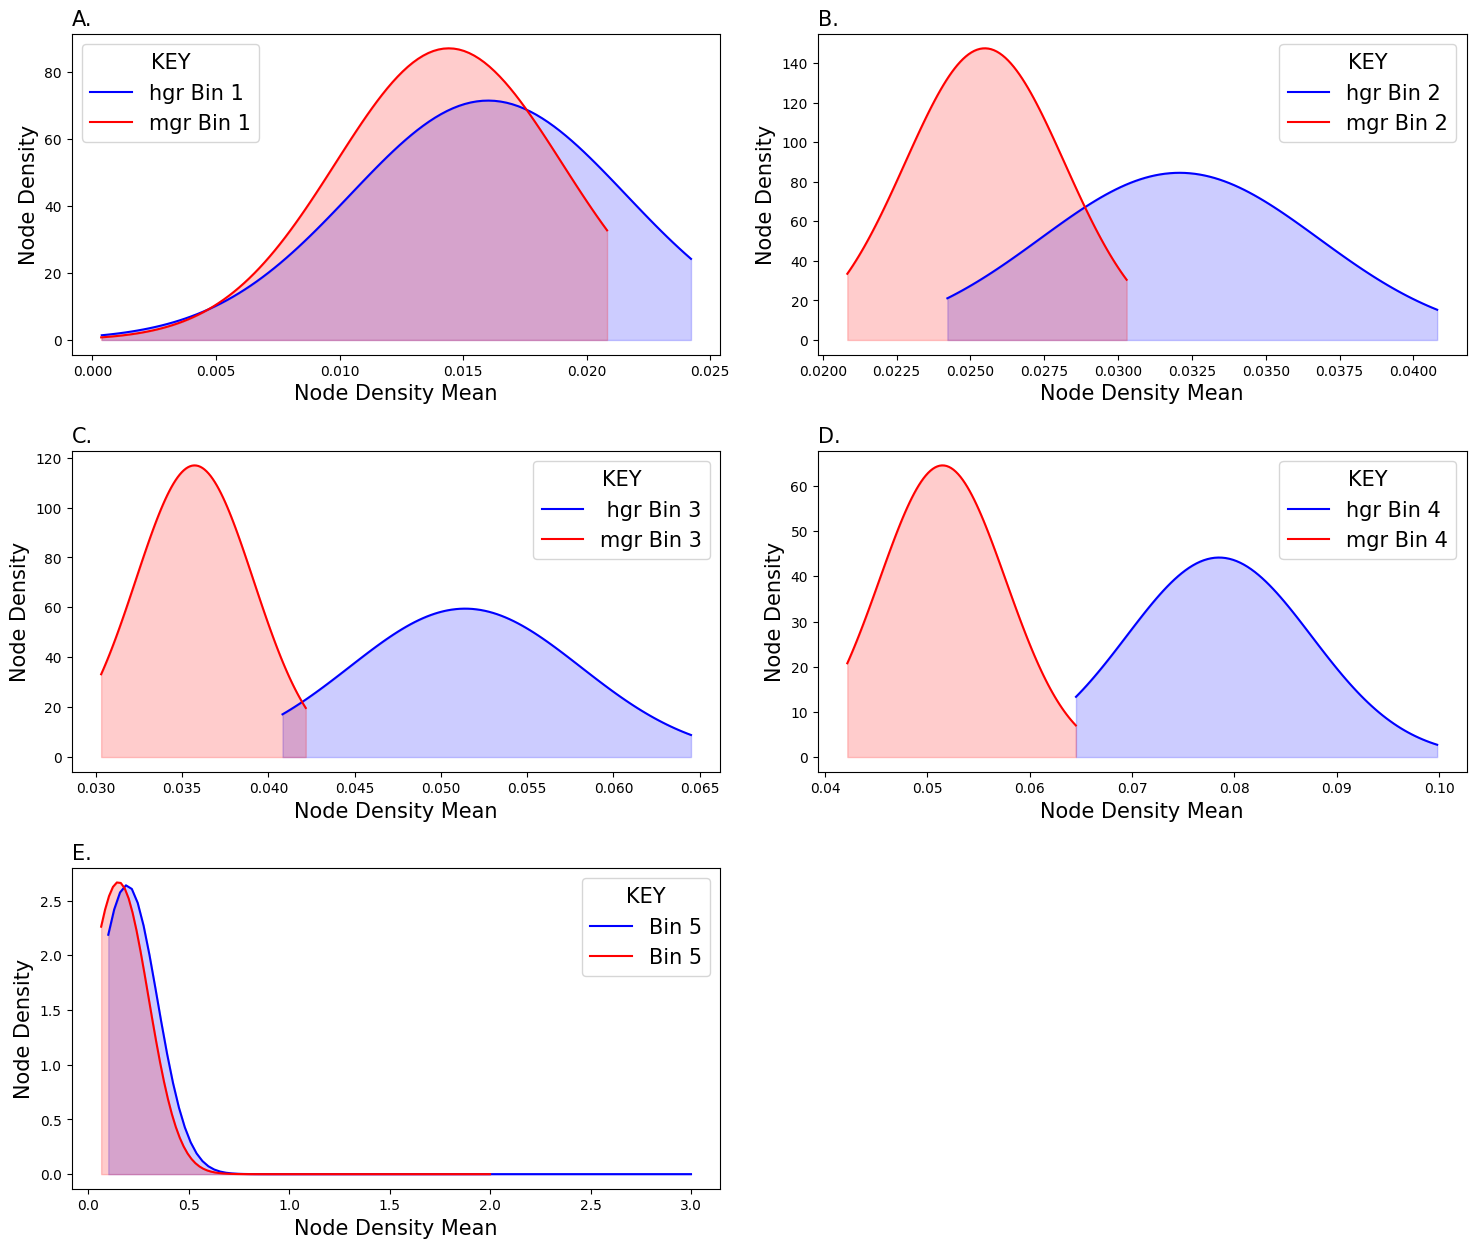

In [61]:
from ctypes import alignment
#Plot the distribution
fig, ax = plt.subplots(3, 2, figsize=(18, 15))

ax[0,0].plot(hgr1_x, hgr1_y, label='hgr Bin 1', color = 'blue')
ax[0,0].fill_between(hgr1_x, hgr1_y, color='blue', alpha=0.2)

ax[0,0].plot(mgr1_x, mgr1_y,  label='mgr Bin 1', color = 'red')
ax[0,0].fill_between(mgr1_x, mgr1_y, color='red', alpha=0.2)





ax[0,1].plot(hgr2_x, hgr2_y,  label='hgr Bin 2', color = 'blue')
ax[0,1].fill_between(hgr2_x, hgr2_y, color='blue', alpha=0.2)


ax[0,1].plot(mgr2_x, mgr2_y,  label='mgr Bin 2', color = 'red')
ax[0,1].fill_between(mgr2_x, mgr2_y, color='red', alpha=0.2)




ax[1,0].plot(hgr3_x, hgr3_y, label=' hgr Bin 3', color = 'blue')
ax[1,0].fill_between(hgr3_x, hgr3_y, color='blue', alpha=0.2)

ax[1,0].plot(mgr3_x, mgr3_y,  label='mgr Bin 3', color = 'red')
ax[1,0].fill_between(mgr3_x, mgr3_y, color='red', alpha=0.2)





ax[1,1].plot(hgr4_x, hgr4_y,  color = 'blue', label='hgr Bin 4')
ax[1,1].fill_between(hgr4_x, hgr4_y, color='blue', alpha=0.2)

ax[1,1].plot(mgr4_x, mgr4_y, label='mgr Bin 4', color = 'red')
ax[1,1].fill_between(mgr4_x, mgr4_y, color='red', alpha=0.2)



ax[2,0].plot(hgr5_x, hgr5_y,  label='Bin 5', color = 'blue')
ax[2,0].fill_between(hgr5_x, hgr5_y, color='blue', alpha=0.2)

ax[2,0].plot(mgr5_x, mgr5_y,  label='Bin 5', color = 'red')
ax[2,0].fill_between(mgr5_x, mgr5_y, color='red', alpha=0.2)



# Increase spacing between subplots
fig.subplots_adjust(hspace=0.3, wspace= 0.15)

ax[2,1].remove()

# Get figure width and height in inches
fig_width, fig_height = fig.get_size_inches()

# Calculate a base font size based on figure dimensions
base_font_size = min(fig_width, fig_height) * 1 # Adjust the multiplier as needed

# Apply font size to legend, labels, and title
ax[0,0].legend(title='KEY', fontsize=base_font_size, title_fontsize=base_font_size )
ax[0,1].legend(title='KEY', fontsize=base_font_size, title_fontsize=base_font_size )
ax[1,0].legend(title='KEY', fontsize=base_font_size, title_fontsize=base_font_size )
ax[1,1].legend(title='KEY', fontsize=base_font_size, title_fontsize=base_font_size )
ax[2,0].legend(title='KEY', fontsize=base_font_size, title_fontsize=base_font_size )

ax[0,0].set_ylabel('Node Density', fontsize=base_font_size)
ax[0,1].set_ylabel('Node Density', fontsize=base_font_size)
ax[1,0].set_ylabel('Node Density', fontsize=base_font_size)
ax[1,1].set_ylabel('Node Density', fontsize=base_font_size)
ax[2,0].set_ylabel('Node Density', fontsize=base_font_size)

ax[0,0].set_xlabel('Node Density Mean', fontsize=base_font_size)
ax[0,1].set_xlabel('Node Density Mean', fontsize=base_font_size)
ax[1,0].set_xlabel('Node Density Mean', fontsize=base_font_size)
ax[1,1].set_xlabel('Node Density Mean', fontsize=base_font_size)
ax[2,0].set_xlabel('Node Density Mean', fontsize=base_font_size)

ax[0,0].set_title('A.', fontsize=base_font_size, loc = 'left')
ax[0,1].set_title('B.', fontsize=base_font_size, loc = 'left')
ax[1,0].set_title('C.', fontsize=base_font_size,loc = 'left')
ax[1,1].set_title('D.', fontsize=base_font_size, loc = 'left')
ax[2,0].set_title('E.', fontsize=base_font_size, loc = 'left')


plt.show()